In [1]:
import dgl
import torch 
import numpy as np
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    g.add_nodes(14)
    edge_list =[(0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 8), (2,23), (3, 8), (4, 9), (5, 9), (6, 7), (7, 8), (7, 9), (8,10), (8,11), (9,10), (9,11),(10,12),(10,13),(11,12),(11,22),(12,22),(13,15),(14,15),(14,20),(14,23),(15,16),(15,18),(16,17),(16,21),(17,20),(18,19),(19,22),(20,21)]
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src,dst)
    g.add_edges(dst,src)
    return g
G = build_karate_club_graph()
print(G.number_of_nodes())

24


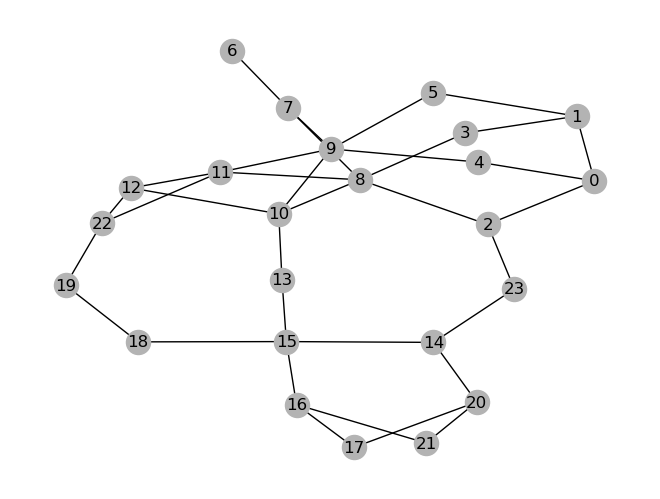

In [4]:
import networkx as nx
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G,pos,with_labels=True, node_color=[[.7,.7,.7]])

In [172]:
ad = nx.adjacency_matrix(nx_G).todense()

C:\Users\tmj89\AppData\Local\Temp\ipykernel_2040\3803018324.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  ad = nx.adjacency_matrix(nx_G).todense()


In [218]:
d_mat = []
for i in range (0,ad.shape[0]):
    d = np.sum(ad[i,:])
    d_mat.append(d)
    


In [235]:
d_mat = [2, 3, 3, 2, 2, 2, 1, 3, 5, 5, 4, 4, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 2]

In [236]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pyomo.environ import *
import os
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font', family = 'Times New Roman')

In [237]:
gen_bus = [0,1,6,12,14,15,17,20,21,22]


In [238]:
def w_generate():
    w = np.zeros([ad.shape[0],ad.shape[1]])
    for i in range(0,ad.shape[0]):
        for j in range(0,ad.shape[1]):
            #w[i,i] =1
            if ad[i,j] == 1: 
                 if i not in gen_bus:
                    index = np.where(ad[j,:]==1)
                    #print (index[1])  
                    for k in index[1]:
                        if k not in gen_bus:
                           w[i,k]= 1
                
    return w
         

In [239]:
w_mat = w_generate()

In [240]:
w_mat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 

In [241]:
model = AbstractModel()

## ****************************************************************************
##						  Sets
## ****************************************************************************
model.Bus_r = Set()
model.Bus_c = Set()

## ****************************************************************************
##						  Variables
## ****************************************************************************
model.a = Param( model.Bus_r,model.Bus_c, mutable=True, within = Binary,initialize= 0)
model.w = Param( model.Bus_r,model.Bus_c, mutable=True, within = Binary,initialize= 0)
model.pmu_avbl_r = Param( model.Bus_r)
model.pmu_avbl_c = Param( model.Bus_c)
model.deg = Param(model.Bus_c,mutable=True, initialize= 0)
model.x = Var( model.Bus_c, within = Binary)
#*****************************************************************************
# Objective Function and Constraints Formulations
#*****************************************************************************
def obj_cost(model):
    return sum(model.a[r,c]*model.x[c]*model.deg[c] + model.w[r,c]*model.x[c]*model.deg[c]  for r in model.Bus_r for c in model.Bus_c) #
model.obj = Objective(rule=obj_cost,sense=maximize)

def x_var_f(model,c):
        return model.x[c] <= model.pmu_avbl_c[c]
model.x_limit = Constraint(model.Bus_c, rule=x_var_f)   

#def x_var_f2(model,r,c):
#        return model.x[c] <= model.pmu_avbl_r[r]
#model.x_limit2 = Constraint(model.Bus_r,model.Bus_c, rule=x_var_f2)

def x_limit_f(model):
        return sum(model.x[c] for c in model.Bus_c)<= 5
model.x_var_limit = Constraint(rule=x_limit_f) 

instance = model.create_instance('./data.dat')


In [242]:
for i in instance.Bus_r:
    for j in instance.Bus_c:
        instance.a[i,j] = ad[i-1,j-1]
        
for i in instance.Bus_r:
    for j in instance.Bus_c:
        instance.w[i,j] = w_mat[i-1,j-1]
        
for j in instance.Bus_c:
        instance.deg[j] = d_mat[j-1]

In [243]:
SCUCsolver = SolverFactory('gurobi')
SCUCsolver.options.mipgap = 0.001
results = SCUCsolver.solve(instance)
print("\nresults.Solution.Status: " + str(results.Solution.Status))
print("\nresults.solver.status: " + str(results.solver.status))
print("\nresults.solver.termination_condition: " + str(results.solver.termination_condition))
print("\nresults.solver.termination_message: " + str(results.solver.termination_message))
print('\nmaximize: ' + str(instance.obj()))


results.Solution.Status: unknown

results.solver.status: ok

results.solver.termination_condition: optimal

results.solver.termination_message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.

maximize: 47.0


In [244]:
for k in range (1,25):
    print(str(instance.x[k]()))

0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
